In [1]:
import cosima_cookbook as cc
import matplotlib.pyplot as plt # to generate plots
import xarray as xr
import pandas as pd
import scipy.interpolate
import scipy.ndimage
from tqdm import tqdm_notebook
import IPython.display
import cmocean as cm
from scipy.io import loadmat
from dask.distributed import Client
import cartopy.crs as ccrs
import cartopy.feature as cft
import matplotlib.ticker as mticker
from collections import OrderedDict
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))  # so we can import ../exptdata
import exptdata
import numpy as np
import cftime
import matplotlib
import warnings
warnings.filterwarnings('ignore')
print('Available exptdata keys: ', [k for k in exptdata.exptdict.keys()])

Available exptdata keys:  ['1deg', '025deg', '025deg_abs', '01deg']


In [2]:
session = cc.database.create_session()

In [72]:
figdir = ''
NOSYNC = 'NOSYNC/' # where to save figs we don't want to sync
if not os.path.exists(NOSYNC):
    os.makedirs(NOSYNC)
def savefigure(fname):
    plt.savefig(os.path.join(figdir, fname+'.png'),dpi=150, bbox_inches="tight")  # comment out to disable saving
    #plt.savefig(os.path.join(figdir, fname+'.pdf'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    return

In [4]:
gs=[-82,-62,22,46]
land = cft.NaturalEarthFeature('physical', 'land', '110m',
                                        edgecolor='black',
                                        facecolor='gray',
                                        linewidth=0.5)
font = { 'family' : 'normal',
         'weight' : 'bold',
         'size'   : 16 }
matplotlib.rc('font', **font)
land_50m = cft.NaturalEarthFeature('physical','land','110m',edgecolor='black',facecolor='gray',linewidth=0.5)
# cmp = plt.get_cmap('gist_ncar_r')  # confusing with the most common form of colourblindness (deuteranomaly)
cmp = plt.get_cmap('nipy_spectral')
cmp3 = cm.cm.thermal
cmp4 = plt.get_cmap('seismic')


# clev = np.arange(0,0.421,0.01)
clev2 = np.arange(-75,75.01,10)
clev3 = np.arange(0,0.8,0.02)
#clev4 = np.arange(-0.25, 0.2501, 0.002)
#clev4 = np.arange(-0.25, 0.2501, 0.001)
clev4 = np.arange(-0.25, 0.26, 0.01)

## GS separation variation

In [7]:
t={'t1':slice('1985-01-01','2009-01-01'),'t2':slice('2009-01-01','2018-01-01')}
e = exptdata.exptdict['01deg']
u = cc.querying.getvar(e['expt'],'u',session,
                                        n=e['n_files'], offset=e['offset'])
v = cc.querying.getvar(e['expt'],'v',session,
                                        n=e['n_files'], offset=e['offset'])
pv= cc.querying.getvar(e['expt'],'vert_pv',session,
                                        n=e['n_files'], offset=e['offset'])

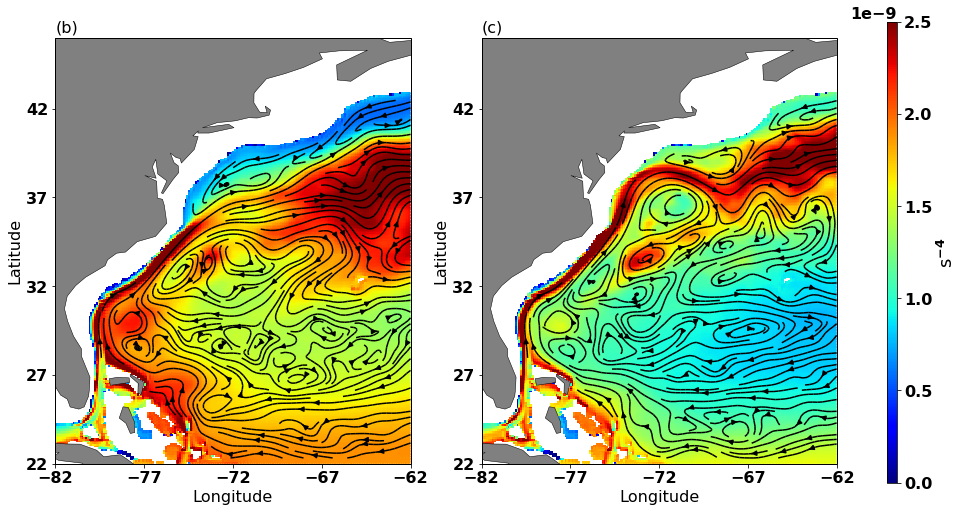

In [13]:
d=400
fig=plt.figure(figsize=(14,8))
for i,time in enumerate(t.values()):
    ut=u.sel(time=time).mean('time').sel(xu_ocean=slice(gs[0],gs[1])).sel(yu_ocean=slice(gs[2],gs[3]))
    vt=v.sel(time=time).mean('time').sel(xu_ocean=slice(gs[0],gs[1])).sel(yu_ocean=slice(gs[2],gs[3]))
    pvt=pv.sel(time=time).mean('time').sel(xt_ocean=slice(gs[0],gs[1])).sel(yt_ocean=slice(gs[2],gs[3]))
    umean=ut.sel(st_ocean=d,method='nearest')
    vmean=vt.sel(st_ocean=d,method='nearest')
    X,Y=np.meshgrid(umean['xu_ocean'].values,umean['yu_ocean'].values)
    ax0=fig.add_subplot(1,2,i+1,projection=ccrs.PlateCarree())
    ax0.set_extent(gs, crs=ccrs.PlateCarree())
    ax0.add_feature(land)
    ax0.set_xticks(np.arange(gs[0],gs[1]+1,5), crs=ccrs.PlateCarree())
    ax0.set_yticks(np.arange(gs[2],gs[3]+1,5), crs=ccrs.PlateCarree())
    ax0.streamplot(X,Y,umean.values,vmean.values,density=2.5,color='k',linewidth=1.5)
    p1=pvt.sel(st_ocean=d,method='nearest').plot(cmap='jet',add_colorbar=False,vmax=2.5e-9,vmin=0)
    plt.title('')
    plt.title('('+chr(i+ord('b'))+')',loc='left',fontsize=16)
    plt.xlabel('Longitude',fontsize=16)
    plt.ylabel('Latitude',fontsize=16)
ax3 = plt.axes([0.95,0.1,0.01,0.8])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
cb.ax.set_ylabel('s$^{-4}$',fontsize=18)
savefigure('gsseparation')

In [14]:
times = [pd.to_datetime('1985', format='%Y')+pd.DateOffset(years=y) for y in range(0,34,4)]
tranges = list(zip(times[0:-1], times[1:]))
tranges.append((times[0],times[-1]))  # also include range covering all requested time ranges

yearranges = [str(pd.to_datetime(t[0]).year)+'-'+str(pd.to_datetime(t[1]).year-1) for t in tranges]
tslices = {y:slice(*t) for y,t in zip(yearranges,tranges)}
tsliceall = slice(min(min(tranges)), max(max(tranges)))  # slice covering all requested times

yearranges 

['1985-1988',
 '1989-1992',
 '1993-1996',
 '1997-2000',
 '2001-2004',
 '2005-2008',
 '2009-2012',
 '2013-2016',
 '1985-2016']

### Transects

In [19]:
transectlon = slice(-75.5,-70)
transectlat = 37
u_transect = u.sel(xu_ocean=transectlon).sel(yu_ocean=transectlat, method='nearest').sel(time=tsliceall)
v_transect = v.sel(xu_ocean=transectlon).sel(yu_ocean=transectlat, method='nearest').sel(time=tsliceall)

In [20]:
u_transects = {}
v_transects = {}
for yr, tslice in tslices.items():
    #print(yr)
    u_transects[yr] = u_transect.sel(time=tslice).mean('time')
    v_transects[yr] = v_transect.sel(time=tslice).mean('time')

plotting 1 in 9
plotting 2 in 9
plotting 3 in 9
plotting 4 in 9
plotting 5 in 9
plotting 6 in 9
plotting 7 in 9
plotting 8 in 9
plotting 9 in 9


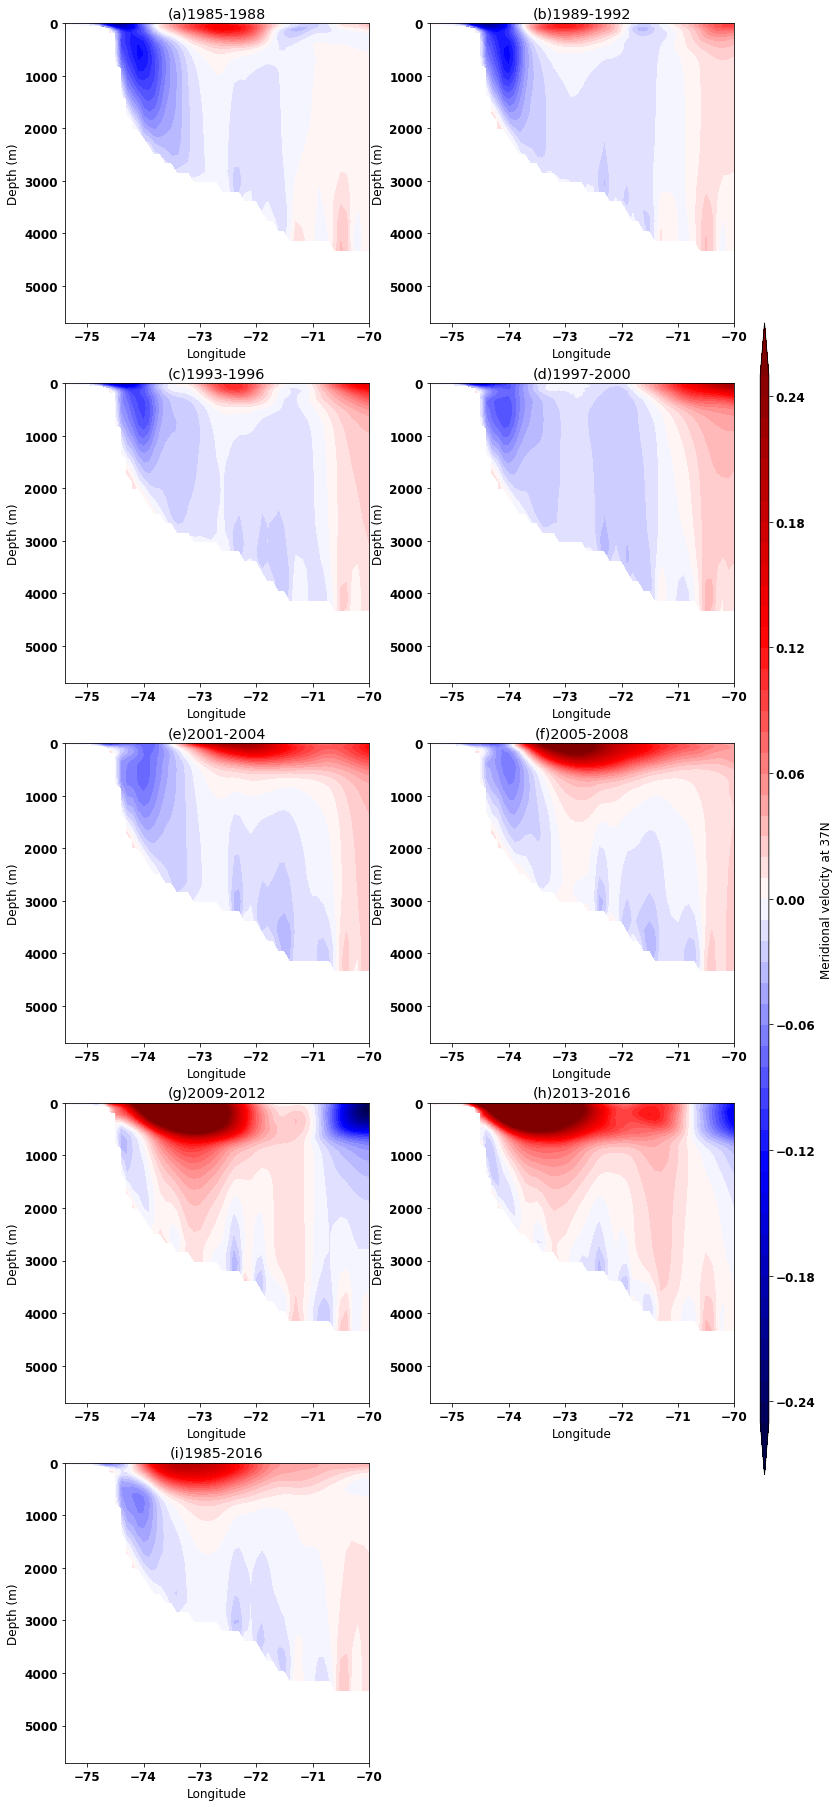

In [27]:
warnings.filterwarnings('ignore')
plt.figure(figsize=(12,32))
for i, (yr, v_gs) in enumerate(v_transects.items()):  
    print('plotting',i+1,'in',len(v_transects))
    ax = plt.subplot((len(v_transects)+1)//2,2,i+1)
    p1 = v_gs.plot.contourf(cmap=cmp4, levels=clev4, extend='both', add_colorbar=False) 
    p1.cmap.set_under(color=cmp4(0), alpha=None)
    p1.cmap.set_over(color=cmp4(255), alpha=None)
    plt.gca().invert_yaxis()
    plt.ylabel('Depth (m)')
    plt.xlabel('Longitude')
    plt.title('('+chr(i+ord('a'))+')'+yr)
ax3 = plt.axes([0.93,0.25,0.01,0.5])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
cb.ax.set_ylabel('Meridional velocity at '+str(abs(transectlat))+'N')
savefigure('gulfstream_v_transect_'+str(abs(transectlat))+'N')

In [15]:
#transectlon = slice(-50,-35)
transectlon = slice(-50,-45)
transectlat = 45
u_transect = u.sel(xu_ocean=transectlon).sel(yu_ocean=transectlat, method='nearest').sel(time=tsliceall)
v_transect = v.sel(xu_ocean=transectlon).sel(yu_ocean=transectlat, method='nearest').sel(time=tsliceall)

In [16]:
u_transects = {}
v_transects = {}
for yr, tslice in tslices.items():
    #print(yr)
    u_transects[yr] = u_transect.sel(time=tslice).mean('time')
    v_transects[yr] = v_transect.sel(time=tslice).mean('time')

plotting 1 in 8
plotting 2 in 8
plotting 3 in 8
plotting 4 in 8
plotting 5 in 8
plotting 6 in 8
plotting 7 in 8
plotting 8 in 8


Text(0, 0.5, 'Meridional velocity at 45N')

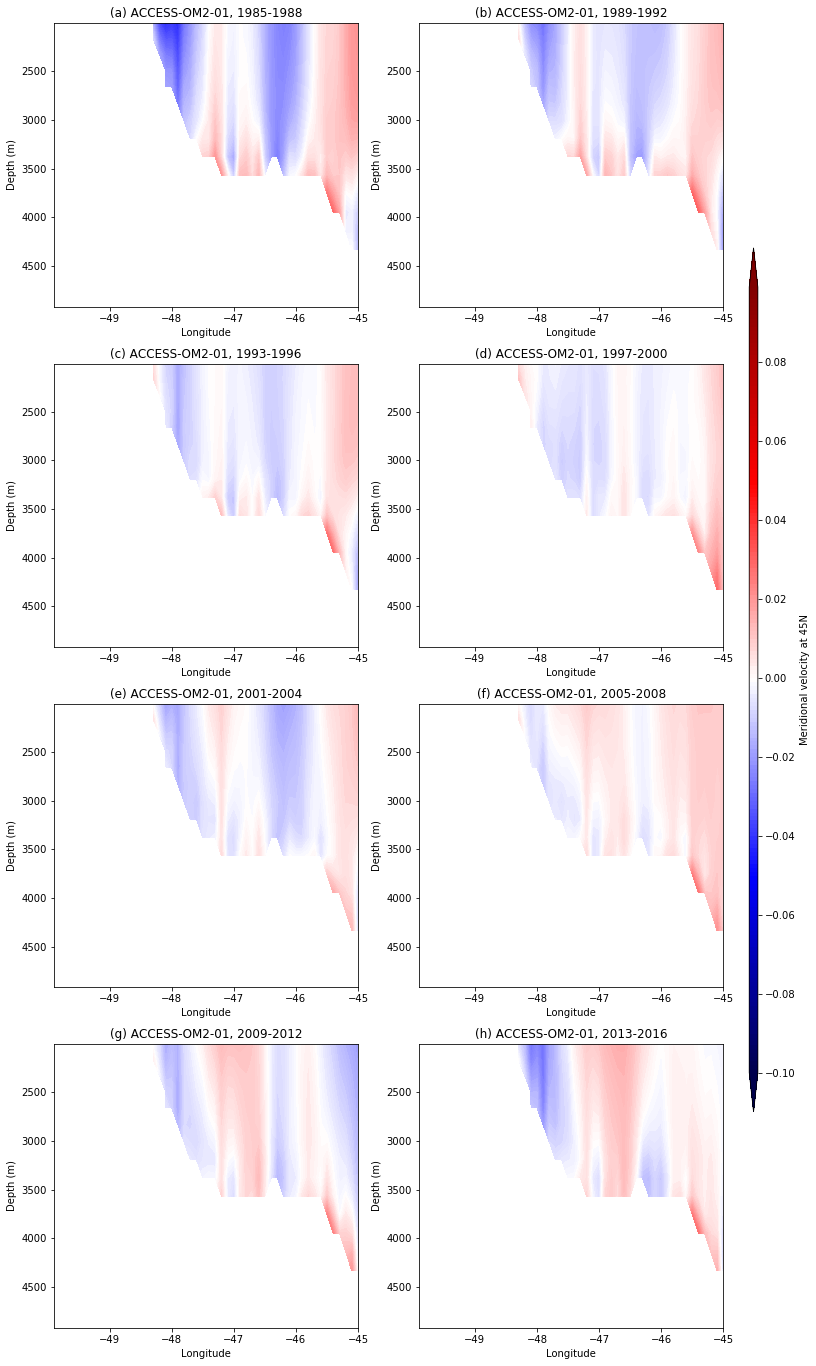

In [20]:
clev4 = np.arange(-0.1, 0.1, 0.001)
plt.figure(figsize=(12,24))
for i, (yr, v_gs) in enumerate(v_transects.items()):  
    print('plotting',i+1,'in',len(v_transects))
    ax = plt.subplot((len(v_transects)+1)//2,2,i+1)
    p1 = v_gs.sel(st_ocean=slice(2000,5000)).plot.contourf(cmap=cmp4, levels=clev4, extend='both', add_colorbar=False) 
    p1.cmap.set_under(color=cmp4(0), alpha=None)
    p1.cmap.set_over(color=cmp4(255), alpha=None)
    plt.gca().invert_yaxis()
    plt.ylabel('Depth (m)')
    plt.xlabel('Longitude')
    plt.title('('+chr(i+ord('a'))+') '+exptdata.exptdict[ekey]['desc']+', '+yr)

ax3 = plt.axes([0.93,0.25,0.01,0.5])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
cb.ax.set_ylabel('Meridional velocity at '+str(abs(transectlat))+'N')
#savefigure('overflow_transect')

### Meridional velocity in deep ocean

In [15]:
vsel=v.sel(xu_ocean=slice(-80,-35)).sel(yu_ocean=slice(30,70)).sel(st_ocean=3000,method='nearest')

plotting 1 in 8
plotting 2 in 8
plotting 3 in 8
plotting 4 in 8
plotting 5 in 8
plotting 6 in 8
plotting 7 in 8
plotting 8 in 8


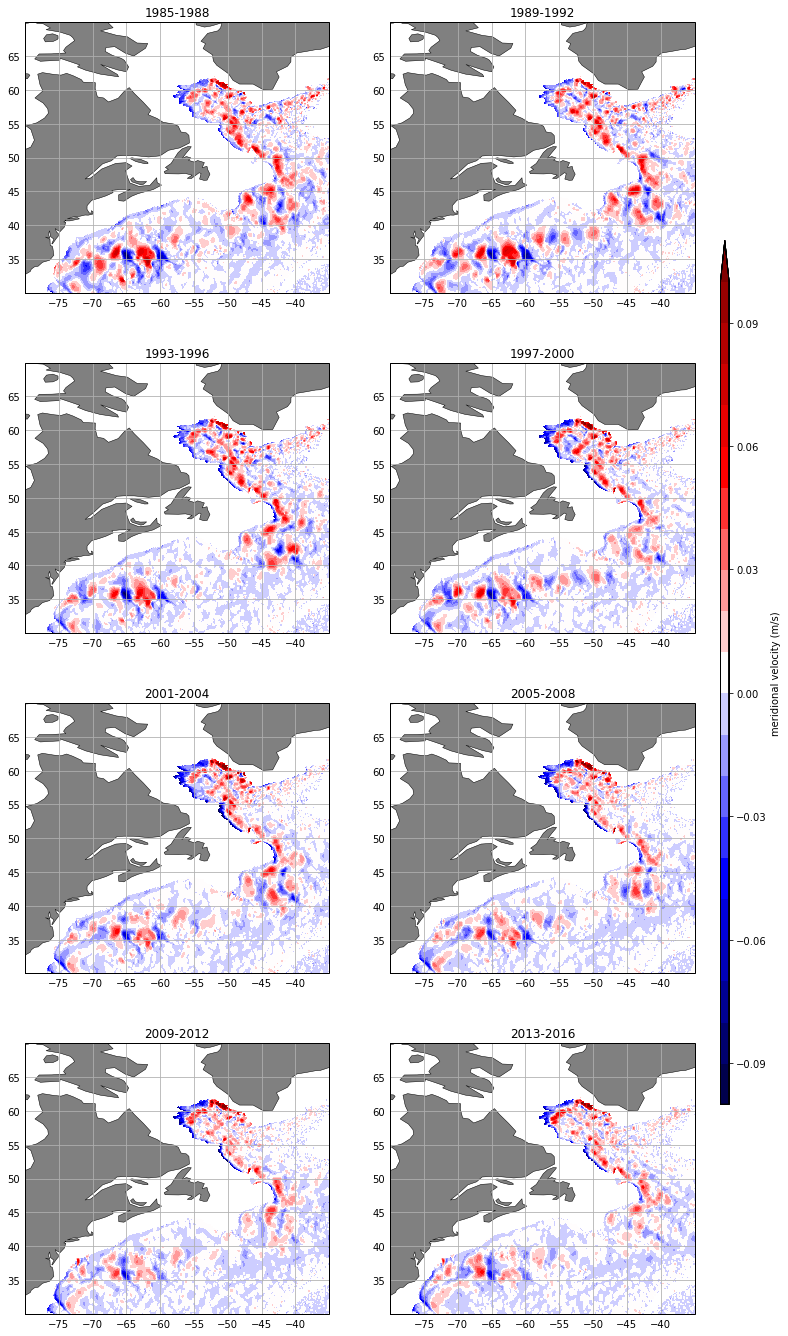

In [16]:
fig=plt.figure(figsize=(12,24))
clev3 = np.arange(-0.1,0.11,0.01)
for i, (yr,t) in enumerate(tslices.items()):
    #gyre_psi = gyre_psi_01deg.sel(time=t).mean('time')
    vmean=vsel.sel(time=t).mean('time')
    print('plotting',i+1,'in',len(tslices.items()))
    ax = plt.subplot(4,2,i+1,projection=ccrs.PlateCarree())
    ax.add_feature(land_50m)
    ax.set_extent([-80,-35,30,70], crs=ccrs.PlateCarree())
    #     ax.set_axis_bgcolor('gray')
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
    gl.xlocator = mticker.FixedLocator(range(-80, -34, 5)) 
    gl.ylocator = mticker.FixedLocator(range(30, 71, 5)) 
    gl.xlabels_top = False
    gl.ylabels_right = False

    p1=vmean.plot.contourf(cmap='seismic', levels=clev3, extend='max', 
                              add_colorbar=False, transform=ccrs.PlateCarree()) 
    #p1.cmap.set_over(color=cmp3(255), alpha=None)
    #gyre_psi.plot.contour(levels=clev2,colors='w',linewidths=0.5,transform=ccrs.PlateCarree())
    #gyre_psi.plot.contour(levels=[0.0,],colorfs='w',linewidths=1.0,transform=ccrs.PlateCarree())
    plt.title(yr)

    ax3 = plt.axes([0.93,0.25,0.01,0.5])
    cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
    cb.ax.set_ylabel('meridional velocity (m/s)')
savefigure('overflow_deep_v1')

## STD of GS 

In [7]:
region = [-90, -45, 15, 45]  # minlon, maxlon, minlat, maxlat
xslice = slice(*region[0:2])
yslice = slice(*region[2:4])

In [5]:
#latest version of cookbook now has a problem with loading diagnostics which exist in daily and monthly ncfile at the same
#time; this section can be run by old verison of cookbook by changing 'cc.querying.getvar' to 'cc.get_nc_variable'
ekey = '01deg'
e = exptdata.exptdict[ekey]
sea_level = cc.querying.getvar(e['expt'],'eta_t',session,ncfile='ocean_daily')\
                              .sel(time=tsliceall)
    
sea_levelsq = cc.querying.getvar(e['expt'],'sea_levelsq',session,
                                 n=e['n_files'], offset=e['offset'])\
                                .sel(time=tsliceall)
sea_level_gs   =   sea_level.sel(xt_ocean=xslice).sel(yt_ocean=yslice)
sea_levelsq_gs = sea_levelsq.sel(xt_ocean=xslice).sel(yt_ocean=yslice)

In [6]:
from joblib import Memory
memory = Memory('.', verbose=0)

In [7]:
@memory.cache
def cacheload(varname,*args):
    """Sufficient optional args should be included to disambiguate each call"""
    return eval(varname+'.load()')

In [8]:
warnings.filterwarnings('ignore')
sla_rmss = {}
for yr, tslice in tslices.items():
    print(yr)
    sea_level_gs_mean   =   sea_level_gs.sel(time=tslice).mean('time')
    sea_levelsq_gs_mean = sea_levelsq_gs.sel(time=tslice).mean('time')
    sla_rms = np.sqrt(sea_levelsq_gs_mean - sea_level_gs_mean**(2.0))
    sla_rmss[yr] = cacheload('sla_rms', region, tslice, ekey)

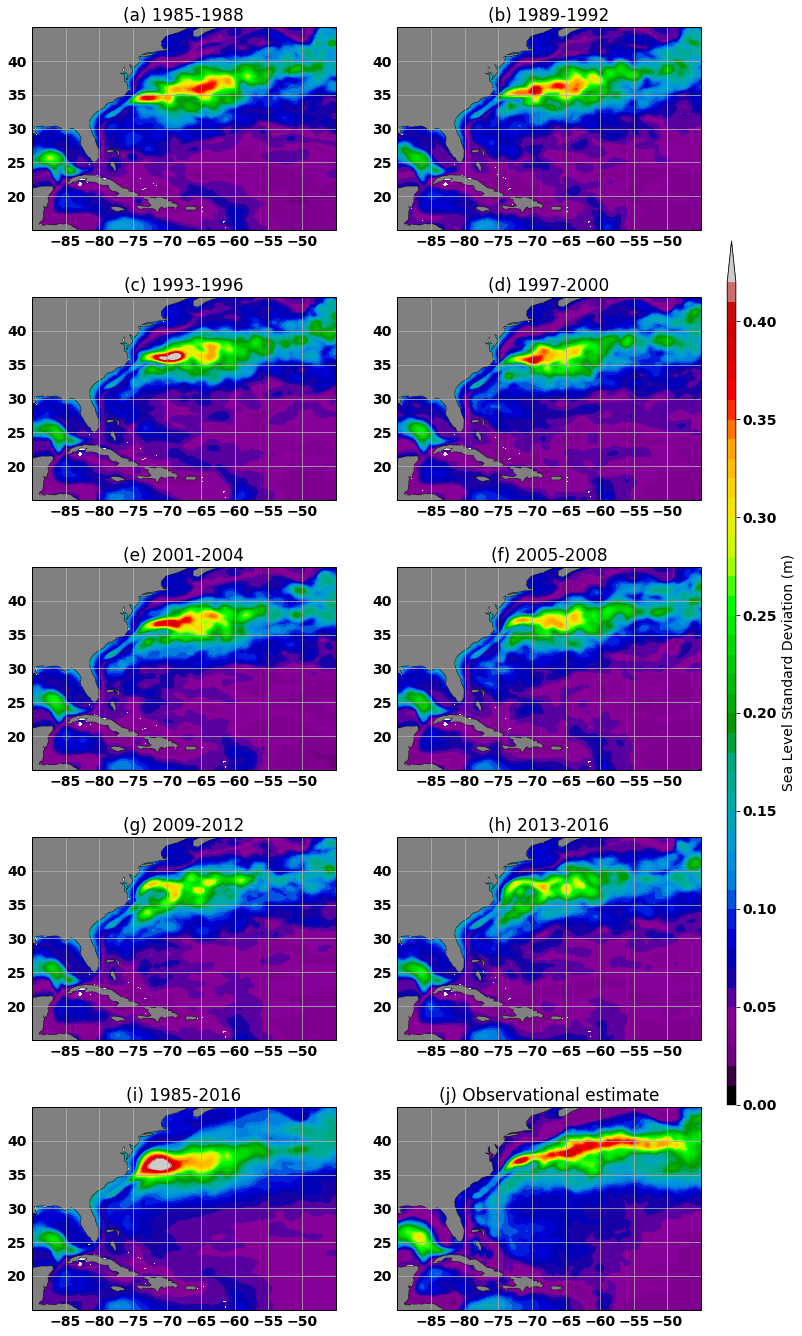

In [23]:
plt.figure(figsize=(12,24))
clev = np.arange(0,0.421,0.01)
clev2 = np.arange(-75,75.01,10)

for i, (yr, sla_rms) in enumerate(sla_rmss.items()):
    #gyre_psi = gyre_psis[yr]
    
    ax = plt.subplot((len(sla_rmss)+1)//2,2,i+1,projection=ccrs.PlateCarree())
    ax.add_feature(land_50m)
    ax.set_extent(region, crs=ccrs.PlateCarree())
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
    gl.xlocator = mticker.FixedLocator(range(region[0], region[1]+1, 5)) #[-95, -90, -70, -50, -30, -10, -5])
    gl.ylocator = mticker.FixedLocator(range(region[2], region[3]+1, 5)) #[10, 15, 25, 35, 45, 55, 65])
    gl.xlabels_top = False
    gl.ylabels_right = False
    
    p1=sla_rms.plot.contourf(cmap=cmp, levels=clev, extend='max', 
                              add_colorbar=False, transform=ccrs.PlateCarree()) 
    p1.cmap.set_over(color=cmp(255), alpha=None)
    #gyre_psi.plot.contour(levels=clev2,colors='w',linewidths=0.5,transform=ccrs.PlateCarree())
    #gyre_psi.plot.contour(levels=[0.0,],colors='w',linewidths=1.0,transform=ccrs.PlateCarree())
    plt.title('('+chr(i+ord('a'))+') '+yr)
    

# now plot obs
i = i+1

ax = plt.subplot((len(sla_rmss)+1)//2,2,i+1,projection=ccrs.PlateCarree())
ax.add_feature(land_50m)
ax.set_extent(region, crs=ccrs.PlateCarree())
    
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.xlocator = mticker.FixedLocator(range(region[0], region[1]+1, 5)) #[-95, -90, -70, -50, -30, -10, -5])
gl.ylocator = mticker.FixedLocator(range(region[2], region[3]+1, 5)) #[10, 15, 25, 35, 45, 55, 65])

gl.xlabels_top = False
gl.ylabels_right = False
p1=SLMA.plot.contourf(cmap=cmp, levels=clev, extend='max', add_colorbar=False, transform=ccrs.PlateCarree()) 
p1.cmap.set_over(color=cmp(255), alpha=None)
#plt.contour(lon,lat,psi,levels=clev2,colors='w',linewidths=0.5,transform=ccrs.PlateCarree())
#plt.contour(lon,lat,psi,levels=[0.0,],colors='w',linewidths=1.0,transform=ccrs.PlateCarree())
plt.title('('+chr(i+ord('a'))+') '+'Observational estimate')

ax3 = plt.axes([0.93,0.25,0.01,0.5])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
cb.ax.set_ylabel('Sea Level Standard Deviation (m)')
savefigure('gulfstream_variability')

## AMOC

In [61]:
expt_amoc=OrderedDict([
    ('iaf', {'run':'01deg_jra55v13_iaf', 'n':None,
                    }),
    #('ryf8485',  {'run':'01deg_jra55v13_ryf8485_spinup6', 'n':-65,
     #               }),
    ('ryf9091',  {'run':'01deg_jra55v13_ryf9091', 'n':None,
                    })
])

In [58]:
expt1='01deg_jra55v13_ryf8485_spinup6_000-413'
expt2='01deg_jra55v13_ryf8485_spinup6'

In [59]:
amoc8485_p1=cc.querying.getvar(expt1,'ty_trans_rho',session,
                          chunks={'potrho': None})
amoc8485_p2=cc.querying.getvar(expt2,'ty_trans_rho',session,n=-65,
                          chunks={'potrho': None})
t1=amoc8485_p1.time.values
tnew=t1
for i,t0 in enumerate(t1):
    tnew[i]=cftime.DatetimeNoLeap(t1[i].year+1899,t1[i].month,t1[i].day)
new8485=xr.concat([a,b], dim='time')

In [68]:
tiaf=new8485.sel(time=cftime.DatetimeNoLeap(1940,1,1),method='nearest').time.values

plotting 8485ryf
plotting 1 in 2
plotting 2 in 2


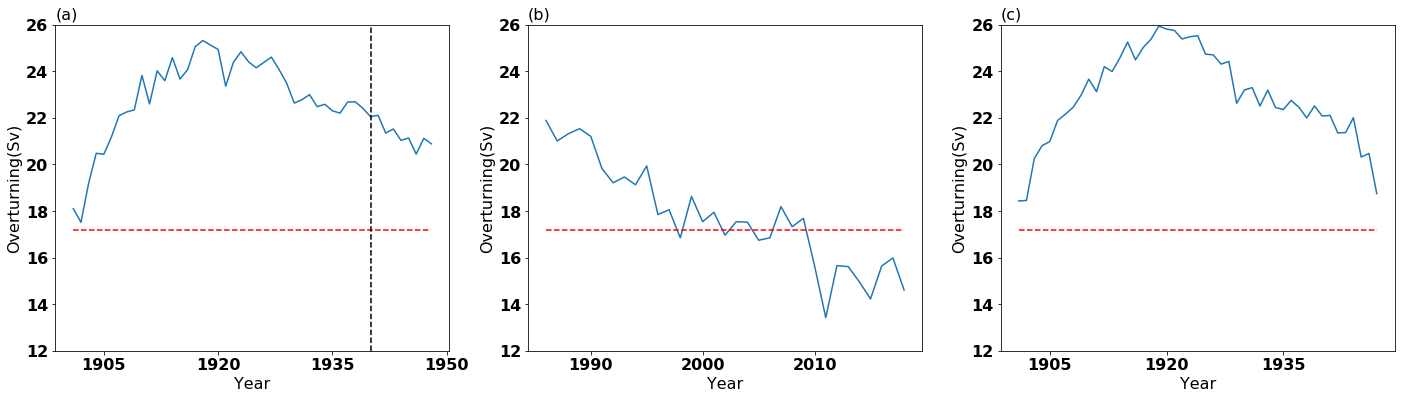

In [74]:
fig=plt.figure(figsize=(24,6))
psi1 = new8485.sel(grid_xt_ocean=slice(-103,-5)).sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=26)*1.0e-9
psi_sum = psi1.cumsum('potrho') - psi1.sum('potrho')
psi_amoc = psi_sum.sel(potrho=slice(1035.5,None))\
            .max('potrho').resample(time='A').mean('time')
ax = plt.subplot(1,3,1)
t = psi_amoc.time
psi_amoc = psi_sum.sel(potrho=slice(1035.5,None))\
                .max('potrho').resample(time='A').mean('time')
psi_amoc.plot()
print('plotting','8485ryf')
plt.plot(t,np.tile(17.2,len(t)),'r--')
y0=np.arange(12,27,1)
plt.plot(np.tile(tiaf,len(y0)),y0,'k--')
plt.ylim(12,26)
plt.xlabel('Year')
plt.ylabel('Overturning(Sv)')
plt.title('')
plt.title('(a)',loc='left',fontsize=16)
for i, experiment in enumerate(expt_amoc.items()):
    expt=experiment[1]['run']
    n=experiment[1]['n']
    psi = cc.querying.getvar(expt,'ty_trans_rho',session,n=n,
                          chunks={'potrho': None})
    psi1 = psi.sel(grid_xt_ocean=slice(-103,-5)).sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=26)*1.0e-9
    psi_sum = psi1.cumsum('potrho') - psi1.sum('potrho')
    psi_amoc = psi_sum.sel(potrho=slice(1035.5,None))\
                .max('potrho').resample(time='A').mean('time')
    ax = plt.subplot(1,3,i+2)
    t = psi_amoc.time
    psi_amoc = psi_sum.sel(potrho=slice(1035.5,None))\
                    .max('potrho').resample(time='A').mean('time')
    psi_amoc.plot()
    print('plotting',i+1,'in','2')
    plt.plot(t,np.tile(17.2,len(t)),'r--')
    plt.ylim(12,26)
    plt.xlabel('Year')
    plt.ylabel('Overturning(Sv)')
    #plt.title(experiment[0])
    plt.title('')
    plt.title('('+chr(i+ord('b'))+')',loc='left',fontsize=16)
savefigure('amoc3')